# Diesel Truck Data (Supervised Learning)

In [1]:
import numpy as np
import pandas as pd
import csv
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import RobustScaler
from sklearn.covariance import MinCovDet
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

from joblib import dump

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#upload cleaned and preprocessed dataset
df_2017_2018_selected_preprocessed = pd.read_parquet('df_2017_2018_selected_preprocessed.parquet')

### Split data to Train, Test and Validation

In [3]:
#training data
df_2017 = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2017-01-01') & 
                                             (df_2017_2018_selected_preprocessed.index < '2018-01-01')]
#testing data
df_2018_jan_july = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2018-01-01') & 
                                                      (df_2017_2018_selected_preprocessed.index < '2018-07-01')]
#validation data
df_2018_aug_dec = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2018-07-01') & 
                                                     (df_2017_2018_selected_preprocessed.index < '2019-01-01')]
#combined data
df_2018 = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2018-01-01') & 
                                             (df_2017_2018_selected_preprocessed.index < '2019-09-01')]

print('all data:', df_2017_2018_selected_preprocessed.shape)
print('training data size:', df_2017.shape)
print('testing data size:', df_2018_jan_july.shape)
print('validation data size:', df_2018_aug_dec.shape)
print('combined dataset:', df_2018.shape)

all data: (305274, 20)
training data size: (182137, 20)
testing data size: (77344, 20)
validation data size: (45793, 20)
combined dataset: (123137, 20)


In [4]:
#split the data into X and y
X_train = df_2017.drop('FuelRate', axis=1)
y_train = df_2017['FuelRate']

#test the model
X_test = df_2018_jan_july.drop('FuelRate', axis=1)
y_test = df_2018_jan_july['FuelRate']

#validate the model
X_val = df_2018_aug_dec.drop('FuelRate', axis=1)
y_val = df_2018_aug_dec['FuelRate']

X_combined = df_2018.drop('FuelRate', axis=1)
y_combined = df_2018['FuelRate']

### Scale Data

In [5]:
# Apply RobustScaler for training data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

X_combined_scaled = scaler.transform(X_combined)

### Tune Hyperparameters of Models

In [6]:
def log_to_csv_and_console(message, log_file='log.csv'):
    print(message)
    with open(log_file, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([message])

# Polynomial Linear Regression
def poly_regression(X_train, y_train, degrees, cv_fold, scoring):
    best_score = -np.inf
    best_degree = None

    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        model = LinearRegression()
        scores = cross_all_score(model, X_train_poly, y_train, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
        score = np.mean(scores)
        log_to_csv_and_console("[Polynomial Linear Regression] (Processing) Score: %f using %s" % (score, degree))
        if score > best_score:
            best_score = score
            best_degree = degree

    log_to_csv_and_console("[Polynomial Linear Regression] Best score: %f using %s" % (best_score, best_degree))
    return best_degree, best_score

# Random Forest Regression
def random_forest_regression(X_train, y_train, param_grid, cv_fold, scoring):
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    log_to_csv_and_console("[Random Forest Regression] Best score: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    return grid_search.best_params_, grid_search.best_score_

# MLP Regression
def mlp_regression(X_train, y_train, param_grid, cv_fold, scoring):
    mlp = MLPRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    log_to_csv_and_console("[MLPRegressor Neural Network] Best score: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
    return grid_search.best_params_, grid_search.best_score_

# Define parameters and perform model training
cv_fold = 5
scoring = "neg_mean_squared_error"
degrees = [2, 3, 4]
# param_grid_rf = {
#                     'n_estimators': [100, 200, 300, 500],
#                     'max_depth': [10, 20, 30, None],
#                     'min_samples_split': [2, 5, 10],
#                     'min_samples_leaf': [1, 2, 4],
#                     'max_features': ['auto', 'sqrt', 'log2'],
#                     'bootstrap': [True, False],
#                 }
param_grid_rf = {
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': [10, 20, None],
                    'n_estimators': [100, 200]
                }
param_grid_mlp = {
                    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  
                    'activation': ['tanh', 'relu'], 
                    'solver': ['adam', 'sgd'],
                    'activation': ['relu'], 
                    'solver': ['adam'],
                    'alpha': [0.0001, 0.001],
                    'learning_rate': ['constant', 'adaptive'],
                    'max_iter': [200, 400],
                    'batch_size': [32, 64]
                }

# best_degree, _ = poly_regression(X_train_scaled, y_train, degrees, cv_fold, scoring)
# [Polynomial Linear Regression] (Processing) Score: -0.485464 using 2
# [Polynomial Linear Regression] (Processing) Score: -0.466042 using 3
# [Polynomial Linear Regression] (Processing) Score: -170.844474 using 4
# best_params_rf, _ = random_forest_regression(X_train_scaled, y_train, param_grid_rf, cv_fold, scoring)
# [Random Forest Regression] Best score: -0.438841 using {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
# best_params_mlp, _ = mlp_regression(X_train_scaled, y_train, param_grid_mlp, cv_fold, scoring)
# [MLPRegressor Neural Network] Best score: -0.399627 using {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 64, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}

# # Save the best model
# # Polynomial Linear Regression
# best_degree, _ = poly_regression(X_train_scaled, y_train, degrees, cv_fold, scoring)
# poly_features = PolynomialFeatures(degree=best_degree)
# X_train_poly = poly_features.fit_transform(X_train_scaled)
# poly_model = LinearRegression()
# poly_model.fit(X_train_poly, y_train)
# dump(poly_model, f'poly_regression.joblib')
# dump(poly_features, f'poly_features.joblib')
# # Random Forest Regression
# best_params_rf, _ = random_forest_regression(X_train_scaled, y_train, param_grid_rf, cv_fold, scoring)
# rf_model = RandomForestRegressor(random_state=42, **best_params_rf).fit(X_train_scaled, y_train)
# dump(rf_model, 'random_forest_regression.joblib')
# # MLP Regression
# best_params_mlp, _ = mlp_regression(X_train_scaled, y_train, param_grid_mlp, cv_fold, scoring)
# mlp_model = MLPRegressor(random_state=42, **best_params_mlp).fit(X_train_scaled, y_train)
# dump(mlp_model, 'mlp_regression.joblib')



### Train the Best Models

In [7]:
# Best parameters calculated from the previous step
best_degree = 3
best_params_rf = {
                    'max_features': 'sqrt',
                    'max_depth': None,
                    'n_estimators': 200
                }
best_params_mlp = {
                    'hidden_layer_sizes': (50, 50),
                    'activation': 'relu',
                    'solver': 'adam',
                    'alpha': 0.0001,
                    'learning_rate': 'constant',
                    'max_iter': 200,
                    'batch_size': 64
                }

poly_features = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_features.fit_transform(X_train_scaled)
poly_model = LinearRegression().fit(X_train_poly, y_train)

# Random Forest Regression
rf_model = RandomForestRegressor(random_state=42, **best_params_rf).fit(X_train_scaled, y_train)

# MLP Regression
mlp_model = MLPRegressor(random_state=42, **best_params_mlp).fit(X_train_scaled, y_train)

# from joblib import load

# # Load the trained models from file
# poly_model = load('poly_regression.joblib')
# poly_features = load('poly_features.joblib')
# rf_model = load('random_forest_regression.joblib')
# mlp_model = load('mlp_regression.joblib')

### Evaluate Trained Models using Test Data 

In [8]:
X_test_poly = poly_features.transform(X_test_scaled)
y_pred_poly = poly_model.predict(X_test_poly)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_mlp = mlp_model.predict(X_test_scaled)

                MSE  MAPE    R2  Accuracy Accuracy (95% CI)
Model                                                      
Polynomial     0.94  0.16  0.94      0.95   0.95 (+/- 0.06)
Random Forest  0.54  0.15  0.97      0.96   0.96 (+/- 0.02)
MLP            0.52  0.15  0.97      0.96   0.96 (+/- 0.02)


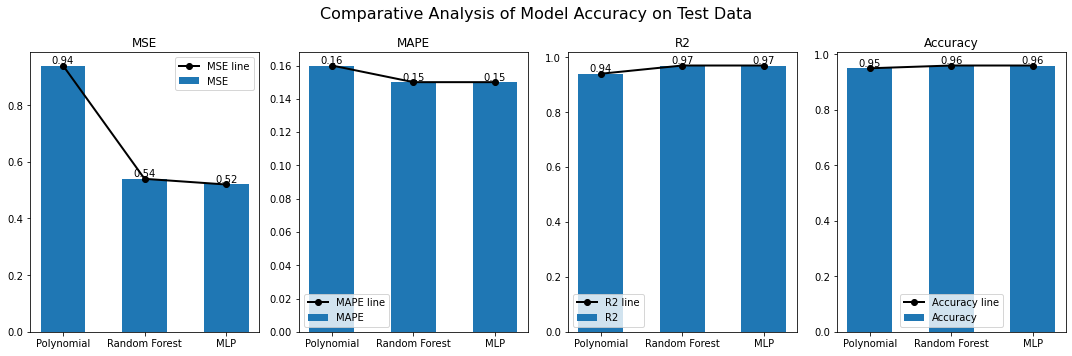

In [9]:
# https://github.com/LNSOTOM/forestGISML/blob/master/polynomial_regression.py

def evaluate_model(model, X, y, y_pred, cv=10):
    # Cross-validation for R2
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    score_mean = round(scores.mean(), 2)
    score_std = round(scores.std(), 2)

    mse = round(mean_squared_error(y, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y, y_pred), 2)
    r2 = round(r2_score(y, y_pred), 2)

    metrics = {
        'MSE': mse,
        'MAPE': mape,
        'R2': r2,
        'Accuracy': score_mean,
        'Accuracy (95% CI)': f"{score_mean} (+/- {2 * score_std})"
    }
    return metrics

results = []
models = [('Polynomial', poly_model, X_test_poly, y_pred_poly),
          ('Random Forest', rf_model, X_test_scaled, y_pred_rf),
          ('MLP', mlp_model, X_test_scaled, y_pred_mlp)]

for name, model, X, y_pred in models:
    result = evaluate_model(model, X, y_test, y_pred)
    result['Model'] = name
    results.append(result)

results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.to_csv('model_performance_comparison.csv', index=True)
print(results_df)

models = results_df.index
# exclude "Accuracy (95% CI)"
metrics = results_df.columns[:-1]

index = np.arange(len(models))
bar_width = 0.55

fig, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
fig.suptitle('Comparative Analysis of Model Accuracy on Test Data', fontsize=16)

for i, metric in enumerate(metrics):
    model_scores = results_df[metric].values
    ax[i].bar(index, model_scores, bar_width, label=metric)

    ax[i].plot(index, model_scores, color='k', marker='o', linestyle='-', linewidth=2, markersize=6, label=f'{metric} line')

    for j, value in enumerate(model_scores):
        ax[i].text(index[j], value, f'{value:.2f}', ha='center', va='bottom')

    ax[i].set_title(metric)
    ax[i].set_xticks(index)
    # ax[i].set_xticklabels(models, rotation=45)
    ax[i].set_xticklabels(models)
    ax[i].legend()

plt.tight_layout()
plt.show()

### Sensitivity Analysis for Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[-0.48482747109111324, -0.4475393912166547, -0.4430729000128128, -0.44060815238770246, -0.4399502409185655]


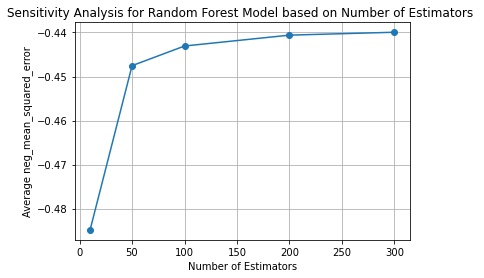

In [10]:
param_grid = {'n_estimators': [10, 50, 100, 200, 300]}
cv_fold = 5
scoring = 'neg_mean_squared_error'


ave_scores = []

for n_estimator in param_grid['n_estimators']:
    
    rf = RandomForestRegressor(random_state=42, n_estimators=n_estimator)

    grid_search = GridSearchCV(estimator=rf, param_grid={}, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    
    ave_score = np.mean(grid_search.cv_results_['mean_test_score'])
    ave_scores.append(ave_score)
    
print(ave_scores)
    
# Plot the results
plt.plot(param_grid['n_estimators'], ave_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Average ' + scoring)
plt.title('Sensitivity Analysis for Random Forest Model based on Number of Estimators ')
plt.grid(True)
plt.show()

### Evaluate Trained Models using Combined Test and Validation data

In [11]:
#Predict y values
X_combined_poly = poly_features.transform(X_combined_scaled)
y_combined_pred_poly = poly_model.predict(X_combined_poly)
y_combined_pred_rf = rf_model.predict(X_combined_scaled)
y_combined_pred_mlp = mlp_model.predict(X_combined_scaled)


                MSE  MAPE    R2  Accuracy Accuracy (95% CI)
Model                                                      
Polynomial     2.62  0.18  0.83      0.95   0.95 (+/- 0.04)
Random Forest  1.00  0.16  0.94      0.96   0.96 (+/- 0.02)
MLP            1.63  0.16  0.90      0.96   0.96 (+/- 0.02)


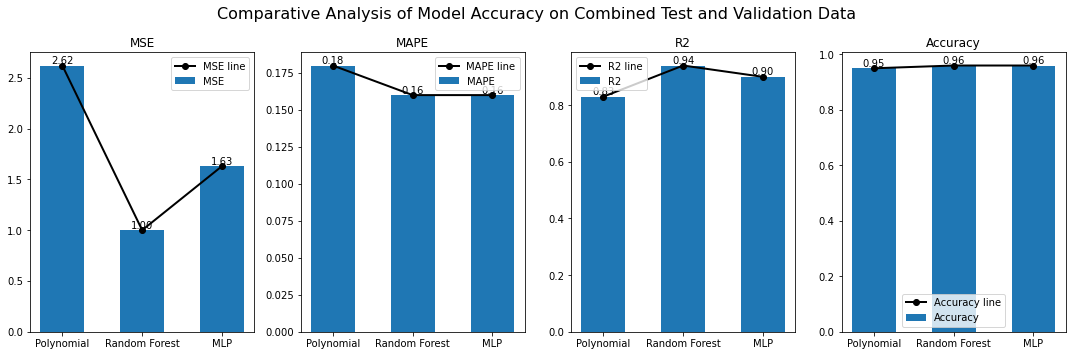

In [12]:
# https://github.com/LNSOTOM/forestGISML/blob/master/polynomial_regression.py

def evaluate_model(model, X, y, y_pred, cv=10):
    # Cross-validation for R2
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    score_mean = round(scores.mean(), 2)
    score_std = round(scores.std(), 2)

    mse = round(mean_squared_error(y, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y, y_pred), 2)
    r2 = round(r2_score(y, y_pred), 2)

    metrics = {
        'MSE': mse,
        'MAPE': mape,
        'R2': r2,
        'Accuracy': score_mean,
        'Accuracy (95% CI)': f"{score_mean} (+/- {2 * score_std})"
    }
    return metrics

results = []
models = [('Polynomial', poly_model, X_combined_poly, y_combined_pred_poly),
          ('Random Forest', rf_model, X_combined_scaled, y_combined_pred_rf),
          ('MLP', mlp_model, X_combined_scaled, y_combined_pred_mlp)]

for name, model, X, y_pred in models:
    result = evaluate_model(model, X, y_combined, y_pred)
    result['Model'] = name
    results.append(result)

results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.to_csv('model_performance_comparison.csv', index=True)
print(results_df)

models = results_df.index
# exclude "Accuracy (95% CI)"
metrics = results_df.columns[:-1]

index = np.arange(len(models))
bar_width = 0.55

fig, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
fig.suptitle('Comparative Analysis of Model Accuracy on Combined Test and Validation Data', fontsize=16)

for i, metric in enumerate(metrics):
    model_scores = results_df[metric].values
    ax[i].bar(index, model_scores, bar_width, label=metric)

    ax[i].plot(index, model_scores, color='k', marker='o', linestyle='-', linewidth=2, markersize=6, label=f'{metric} line')

    for j, value in enumerate(model_scores):
        ax[i].text(index[j], value, f'{value:.2f}', ha='center', va='bottom')

    ax[i].set_title(metric)
    ax[i].set_xticks(index)
    # ax[i].set_xticklabels(models, rotation=45)
    ax[i].set_xticklabels(models)
    ax[i].legend()

plt.tight_layout()
plt.show()

### Feature Importance Analysis using Combined Test and Validation Data

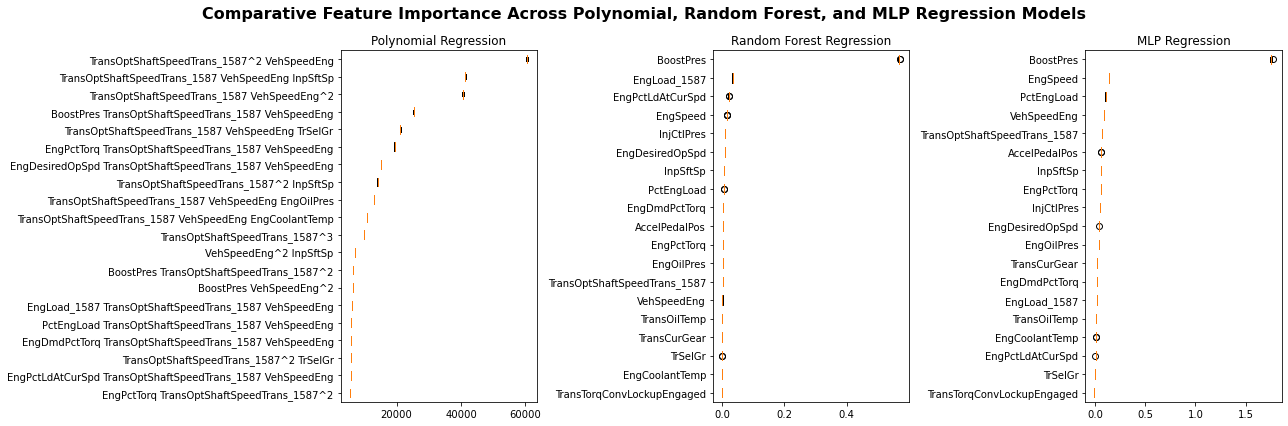

In [13]:
# https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa

from sklearn.inspection import permutation_importance

# Function to calculate permutation importance and plot it
def plot_permutation_importance(model, X, y, ax, feature_names, title, top_n_features=20):

    results = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Sort the features by importance
    sorted_idx = results.importances_mean.argsort()
    if top_n_features > len(sorted_idx):
        top_n_features = len(sorted_idx)
    sorted_idx_top = sorted_idx[-top_n_features:]

    sorted_feature_names = [feature_names[i] for i in sorted_idx_top] if feature_names is not None else sorted_idx_top

    ax.boxplot(results.importances[sorted_idx_top].T, vert=False, labels=sorted_feature_names)
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparative Feature Importance Across Polynomial, Random Forest, and MLP Regression Models', fontsize=16, fontweight='bold')

feature_names = X_combined.columns
# feature_names_poly = poly_features.get_feature_names_out(input_features=X_val.columns)
try:
    feature_names_poly = poly_features.get_feature_names_out(input_features=X_combined.columns)
except AttributeError:
    feature_names_poly = poly_features.get_feature_names(input_features=X_combined.columns)
# Polynomial Regression model
plot_permutation_importance(poly_model, X_combined_poly, y_combined, axs[0], feature_names_poly, "Polynomial Regression")
# Random Forest model
plot_permutation_importance(rf_model, X_combined_scaled, y_combined, axs[1], feature_names, "Random Forest Regression")
# MLP Regression model
plot_permutation_importance(mlp_model, X_combined_scaled, y_combined, axs[2], feature_names, "MLP Regression")

plt.tight_layout()
plt.show()

### Error Analysis using Combined Test and Validation Data

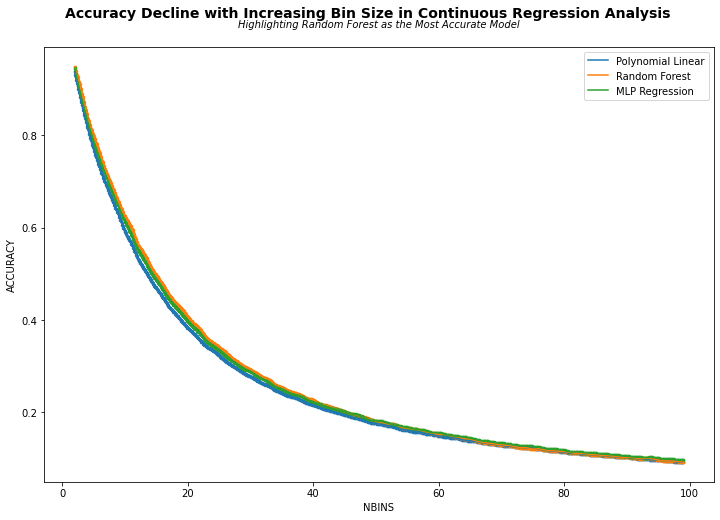

In [14]:
# https://medium.com/@dave.cote.msc/experimenting-confusion-matrix-for-regression-a-powerfull-model-analysis-tool-7c288d99d437

# Define the range of bin counts to test
bin_counts = np.arange(2, 100) 

df_accuracy_poly = pd.DataFrame(columns=['NBINS', 'ACCURACY'])
df_accuracy_rf = pd.DataFrame(columns=['NBINS', 'ACCURACY'])
df_accuracy_mlp = pd.DataFrame(columns=['NBINS', 'ACCURACY'])

# Calculate accuracies for each bin count and store in the corresponding dataframe
for nbins in bin_counts:
    # Discretize the actual and predicted values
    y_true_binned = pd.qcut(y_combined, q=nbins, labels=False, duplicates='drop')
    y_pred_poly_binned = pd.qcut(y_combined_pred_poly, q=nbins, labels=False, duplicates='drop')
    y_pred_rf_binned = pd.qcut(y_combined_pred_rf, q=nbins, labels=False, duplicates='drop')
    y_pred_mlp_binned = pd.qcut(y_combined_pred_mlp, q=nbins, labels=False, duplicates='drop')
    
    # Calculate accuracy for each model
    accuracy_poly = accuracy_score(y_true_binned, y_pred_poly_binned)
    accuracy_rf = accuracy_score(y_true_binned, y_pred_rf_binned)
    accuracy_mlp = accuracy_score(y_true_binned, y_pred_mlp_binned)
    
    # Store the results
    df_accuracy_poly = df_accuracy_poly.append({'NBINS': nbins, 'ACCURACY': accuracy_poly}, ignore_index=True)
    df_accuracy_rf = df_accuracy_rf.append({'NBINS': nbins, 'ACCURACY': accuracy_rf}, ignore_index=True)
    df_accuracy_mlp = df_accuracy_mlp.append({'NBINS': nbins, 'ACCURACY': accuracy_mlp}, ignore_index=True)

# Interpolate accuracies for plotting
f_poly = interp1d(df_accuracy_poly['NBINS'], df_accuracy_poly['ACCURACY'], kind='quadratic')
f_rf = interp1d(df_accuracy_rf['NBINS'], df_accuracy_rf['ACCURACY'], kind='quadratic')
f_mlp = interp1d(df_accuracy_mlp['NBINS'], df_accuracy_mlp['ACCURACY'], kind='quadratic')

# Create the x-axis for plotting
bins_poly = np.linspace(bin_counts.min(), bin_counts.max(), 1000)
y_poly = f_poly(bins_poly)
bins_rf = np.linspace(bin_counts.min(), bin_counts.max(), 1000)
y_rf = f_rf(bins_rf)
bins_mlp = np.linspace(bin_counts.min(), bin_counts.max(), 1000)
y_mlp = f_mlp(bins_mlp)

with plt.rc_context({'figure.facecolor': 'white'}):
    fig, ax = plt.subplots(figsize = (12, 8))
    fig.suptitle('Accuracy Decline with Increasing Bin Size in Continuous Regression Analysis', fontsize=14, fontweight='bold', y=0.95)
    ax.set_title('Highlighting Random Forest as the Most Accurate Model', fontsize=10, style='italic', pad=20)
    ax.set_ylabel('ACCURACY')
    ax.set_xlabel('NBINS' )
    ax.plot(bins_poly, y_poly, label = 'Polynomial Linear' )
    ax.scatter(bins_poly, y_poly, s = 6)
    ax.plot(bins_rf, y_rf, label = 'Random Forest')
    ax.scatter (bins_rf, y_rf, s = 6)
    ax.plot(bins_mlp, y_mlp, label = 'MLP Regression' )
    ax.scatter (bins_mlp, y_mlp, s = 6)
    plt.legend()
    plt.show()

# # Create the x-axis for plotting
# new_bins = np.linspace(bin_counts.min(), bin_counts.max(), 1000)

# # Plot the results
# plt.figure(figsize=(12, 8))
# plt.plot(new_bins, f_poly(new_bins), label='Linear Regression')
# plt.plot(new_bins, f_rf(new_bins), label='CatBoost')
# plt.plot(new_bins, f_poly(new_bins), label='Polynomial Regression')
# # plt.scatter(df_accuracy_poly['NBINS'], df_accuracy_poly['ACCURACY'])  # Add actual data points
# # plt.scatter(df_accuracy_rf['NBINS'], df_accuracy_rf['ACCURACY'])  # Add actual data points
# # plt.scatter(df_accuracy_mlp['NBINS'], df_accuracy_mlp['ACCURACY'])  # Add actual data points
# plt.title('Accuracy vs. Number of Bins')
# plt.xlabel('NBINS')
# plt.ylabel('ACCURACY')
# plt.legend()
# plt.show()

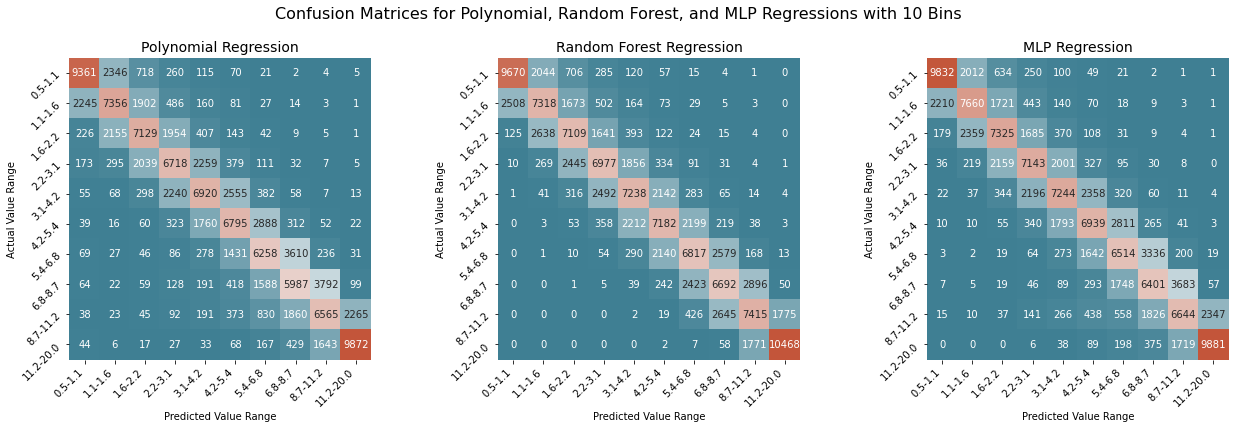

In [15]:
nbins = 10

# Discretize the actual and predicted values
y_true_binned, bins = pd.qcut(y_combined, q=nbins, labels=False, duplicates='drop', retbins=True)
y_pred_poly_binned = pd.qcut(y_combined_pred_poly, q=nbins, labels=False, duplicates='drop')
y_pred_rf_binned = pd.qcut(y_combined_pred_rf, q=nbins, labels=False, duplicates='drop')
y_pred_mlp_binned = pd.qcut(y_combined_pred_mlp, q=nbins, labels=False, duplicates='drop')

cm_poly = confusion_matrix(y_true_binned, y_pred_poly_binned)
cm_rf = confusion_matrix(y_true_binned, y_pred_rf_binned)
cm_mlp = confusion_matrix(y_true_binned, y_pred_mlp_binned)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle('Confusion Matrices for Polynomial, Random Forest, and MLP Regressions with 10 Bins', fontsize=16)

cmap = sns.diverging_palette(220, 20, as_cmap=True)

titles = ['Polynomial Regression', 'Random Forest Regression', 'MLP Regression']
cms = [cm_poly, cm_rf, cm_mlp]

bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

for ax, cm, title in zip(axes.flat, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False, square=True)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Value Range')
    ax.set_ylabel('Actual Value Range')
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    ax.set_yticklabels(bin_labels, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Evaluate the Performance of Models in Outlier Detection

In [16]:
# Calculate the residuals (difference) between actual and predicted values

absolute_residuals_poly = np.abs(y_combined - y_combined_pred_poly)
absolute_residuals_rf = np.abs(y_combined - y_combined_pred_rf)
absolute_residuals_mlp = np.abs(y_combined - y_combined_pred_mlp)

# Identify outliers based on a threshold for the residuals
threshold_poly = np.percentile(absolute_residuals_poly, 95)  # 95 percentile 
threshold_rf = np.percentile(absolute_residuals_rf, 95)  # 95 percentile 
threshold_mlp = np.percentile(absolute_residuals_mlp, 95)  # 95 percentile 

outliers_poly = absolute_residuals_poly > threshold_poly
outliers_rf = absolute_residuals_rf > threshold_rf
outliers_mlp = absolute_residuals_mlp > threshold_mlp

#print(outliers)
print('number of outliers with Polynomial:', sum(outliers_poly))
print('number of outliers with Random Forest:', sum(outliers_rf))
print('number of outliers with MLP:', sum(outliers_mlp))


number of outliers with Polynomial: 6157
number of outliers with Random Forest: 6157
number of outliers with MLP: 6157


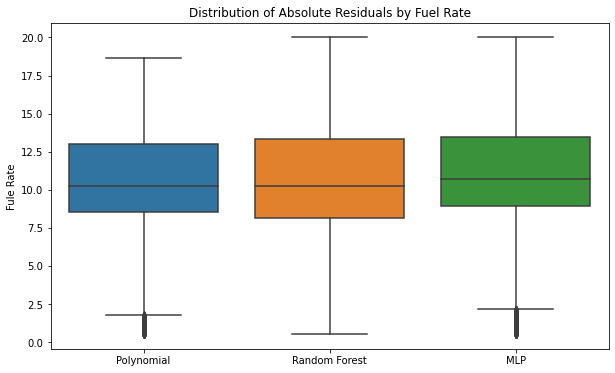

In [17]:
y_ab_residuals = {'Polynomial': y_combined[outliers_poly], 'Random Forest': y_combined[outliers_rf], 'MLP': y_combined[outliers_mlp] }
box_df = pd.DataFrame(y_ab_residuals)

plt.figure(figsize=(10, 6))
sns.boxplot(data= box_df)
plt.title('Distribution of Absolute Residuals by Fuel Rate')
plt.ylabel('Fule Rate')
plt.show()

### Comparative Analysis of Patterns in Absolute Residuals 

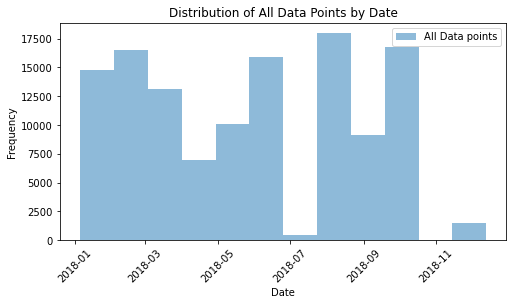

In [49]:
plt.figure(figsize=(8,4))

#All data points
plt.hist(X_combined.index, bins=12, alpha=0.5, label='All Data points')
plt.title('Distribution of All Data Points by Date')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

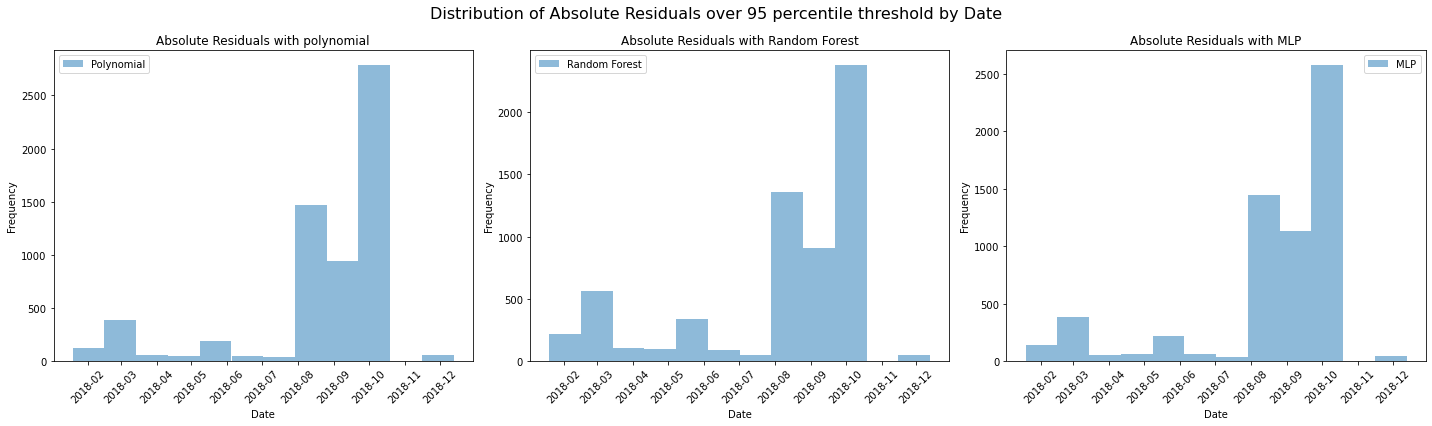

In [52]:
plt.figure(figsize=(20,6))
# Polynomial
plt.subplot(1, 3, 1)
plt.hist(X_combined.index[outliers_poly], bins=12, alpha=0.5, label='Polynomial')
plt.title('Absolute Residuals with polynomial')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(X_combined.index[outliers_rf], bins=12, alpha=0.5, label='Random Forest')
plt.title('Absolute Residuals with Random Forest')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

# MLP
plt.subplot(1, 3, 3)
plt.hist(X_combined.index[outliers_mlp], bins=12, alpha=0.5, label='MLP')
plt.title('Absolute Residuals with MLP')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Distribution of Absolute Residuals over 95 percentile threshold by Date', fontsize=16)

plt.tight_layout()
plt.show()

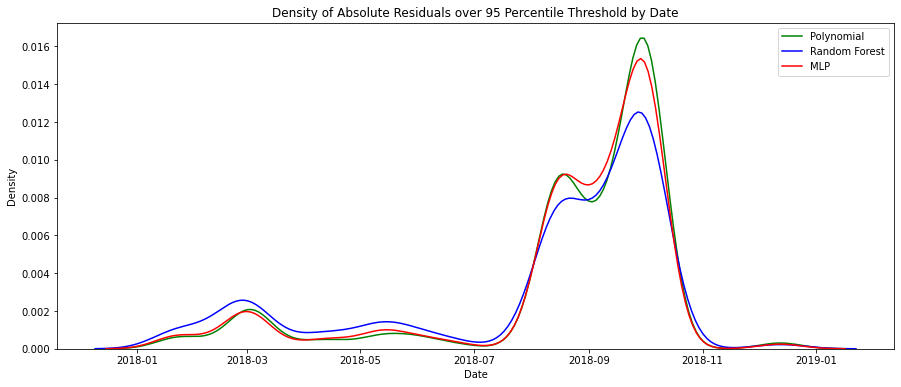

In [34]:
plt.figure(figsize=(15, 6))

# Polynomial
sns.kdeplot(X_combined.index[outliers_poly], color='green', label='Polynomial')

# Random Forest
sns.kdeplot(X_combined.index[outliers_rf], color='blue', label='Random Forest')

# MLP
sns.kdeplot(X_combined.index[outliers_mlp], color='red', label='MLP')

plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Absolute Residuals over 95 Percentile Threshold by Date')
plt.legend()

plt.show()

In [20]:
##euclidean_distance
similarity_rf_mlp = np.linalg.norm(np.array(X_combined.index[outliers_rf]) - np.array(X_combined.index[outliers_mlp]))
similarity_rf_poly = np.linalg.norm(np.array(X_combined.index[outliers_rf]) - np.array(X_combined.index[outliers_poly]))
similarity_mlp_poly = np.linalg.norm(np.array(X_combined.index[outliers_mlp]) - np.array(X_combined.index[outliers_poly]))
print('similarity_rf_mlp:', similarity_rf_mlp)
print('similarity_rf_poly:', similarity_rf_poly)
print('similarity_mlp_poly:', similarity_mlp_poly)

similarity_rf_mlp: 1.990848052299721e+17
similarity_rf_poly: 2.2031644967998854e+17
similarity_mlp_poly: 4.800142211813063e+16


In [21]:
##Result: Presence of outliers or anomalies in the combined data may lead to high residual errors in certain areas, 
##as the model may struggle to fit the data accurately in the presence of extreme values.

### More Exploratory Analysis to Detect Outliers

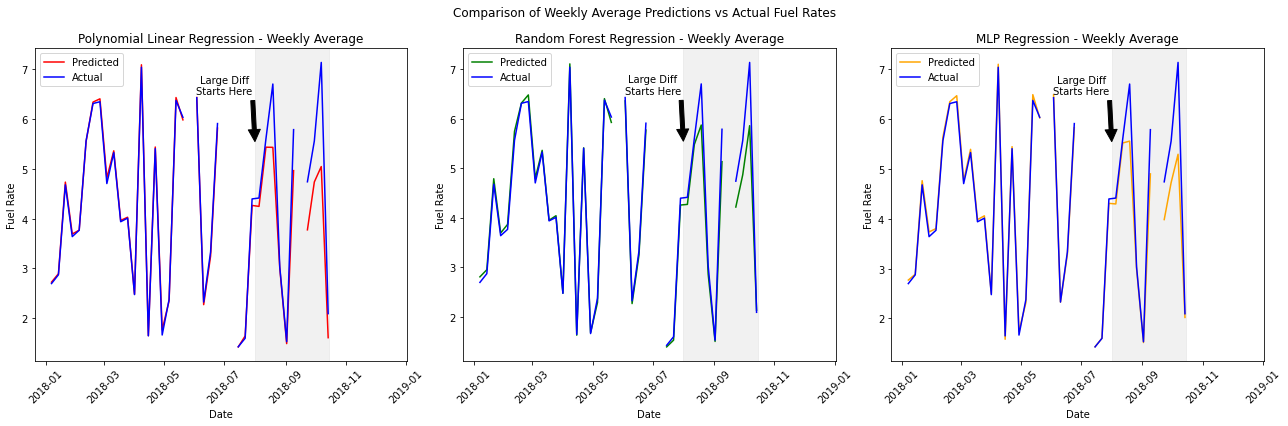

In [22]:
# Resample the actual and predicted data to weekly averages
weekly_actual = y_combined.resample('W').mean()
weekly_pred_poly = pd.Series(y_combined_pred_poly, index=y_combined.index).resample('W').mean()
weekly_pred_rf = pd.Series(y_combined_pred_rf, index=y_combined.index).resample('W').mean()
weekly_pred_mlp = pd.Series(y_combined_pred_mlp, index=y_combined.index).resample('W').mean()

plt.figure(figsize=(18, 6))

# Polynomial Linear Regression Predictions
plt.subplot(1, 3, 1)
plt.plot(weekly_pred_poly.index, weekly_pred_poly, label='Predicted', color='red')
plt.plot(weekly_actual.index, weekly_actual, label='Actual', color='blue')
plt.title('Polynomial Linear Regression - Weekly Average')
plt.xlabel('Date')
plt.ylabel('Fuel Rate')
plt.xticks(rotation=45)
plt.legend()

# Random Forest Regression Predictions
plt.subplot(1, 3, 2)
plt.plot(weekly_pred_rf.index, weekly_pred_rf, label='Predicted', color='green')
plt.plot(weekly_actual.index, weekly_actual, label='Actual', color='blue')
plt.title('Random Forest Regression - Weekly Average')
plt.xlabel('Date')
plt.ylabel('Fuel Rate')
plt.xticks(rotation=45)
plt.legend()

# MLP Regression Predictions
plt.subplot(1, 3, 3)
plt.plot(weekly_pred_mlp.index, weekly_pred_mlp, label='Predicted', color='orange')
plt.plot(weekly_actual.index, weekly_actual, label='Actual', color='blue')
plt.title('MLP Regression - Weekly Average')
plt.xlabel('Date')
plt.ylabel('Fuel Rate')
plt.xticks(rotation=45)
plt.legend()

# Add annotation about the significant deviations
annotate_loc = '2018-07-01'
start_highlight = '2018-08-01'
end_highlight = '2018-10-15'

for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.axvspan(pd.to_datetime(start_highlight), pd.to_datetime(end_highlight), color='lightgrey', alpha=0.3)
        plt.annotate('Large Diff\nStarts Here', xy=(pd.to_datetime(start_highlight), 5.5),
                     xytext=(pd.to_datetime(annotate_loc), 6.5),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     ha='center')

plt.suptitle('Comparison of Weekly Average Predictions vs Actual Fuel Rates')

plt.tight_layout()
plt.show()

### Comare the performance of Mahalanobis Distances with Supervised Leanring Models in Outlier Detection 

In [24]:
def detect_outliers_with_mahalanobis(df):

    # Fit Minimum Covariance Determinant (MCD) estimator
    mcd_estimator = MinCovDet()
    mcd_estimator.fit(df)

    # Calculate Mahalanobis Distances 
    mahalanobis_distances = mcd_estimator.mahalanobis(df)
    
    #Identify outliers based on Mahalanobis distances
    threshold = np.percentile(mahalanobis_distances, 95)

    outliers = mahalanobis_distances > threshold    
    

    # Evaluate performance
    # Print the number of outliers detected 
    num_outliers = sum(outliers)
   
    print("Number of outliers detected:", num_outliers)
       
    return (mahalanobis_distances, outliers, num_outliers, threshold)

In [25]:
catogorical_columns = ['TrSelGr','TransCurGear', 'TransTorqConvLockupEngaged']
unsupervised_df = df_2017_2018_selected_preprocessed.drop(catogorical_columns, axis = 1)
unsupervised_df =  unsupervised_df[(unsupervised_df.index > '2018-01-01') & (unsupervised_df.index < '2019-01-01')]

scaler = RobustScaler()

unsupervised_df_scaled = pd.DataFrame(scaler.fit_transform(unsupervised_df), columns=unsupervised_df.columns,
                       index=unsupervised_df.index)

In [26]:
mahalanobis_function = detect_outliers_with_mahalanobis(unsupervised_df_scaled)

mahalanobis_distances = mahalanobis_function[0]
outliers_mahalanobis = mahalanobis_function[1]
num_outliers_mahalanobis = mahalanobis_function[2]
threshold_mahalanobis = mahalanobis_function[3]

Number of outliers detected: 6157


In [53]:
##euclidean_distance
similarity_poly_mah = np.linalg.norm(np.array(X_combined.index[outliers_poly]) - np.array(unsupervised_df_scaled.index[outliers_mahalanobis]))
similarity_rf_mah = np.linalg.norm(np.array(X_combined.index[outliers_rf]) - np.array(unsupervised_df_scaled.index[outliers_mahalanobis]))
similarity_mlp_mah = np.linalg.norm(np.array(X_combined.index[outliers_mlp]) - np.array(unsupervised_df_scaled.index[outliers_mahalanobis]))

print('similarity_poly_mah:', similarity_poly_mah)
print('similarity_rf_mah:', similarity_rf_mah)
print('similarity_mlp_mah:', similarity_mlp_mah)

similarity_poly_mah: 5.191790018172174e+16
similarity_rf_mah: 2.352811464419143e+17
similarity_mlp_mah: 7.844689401851608e+16


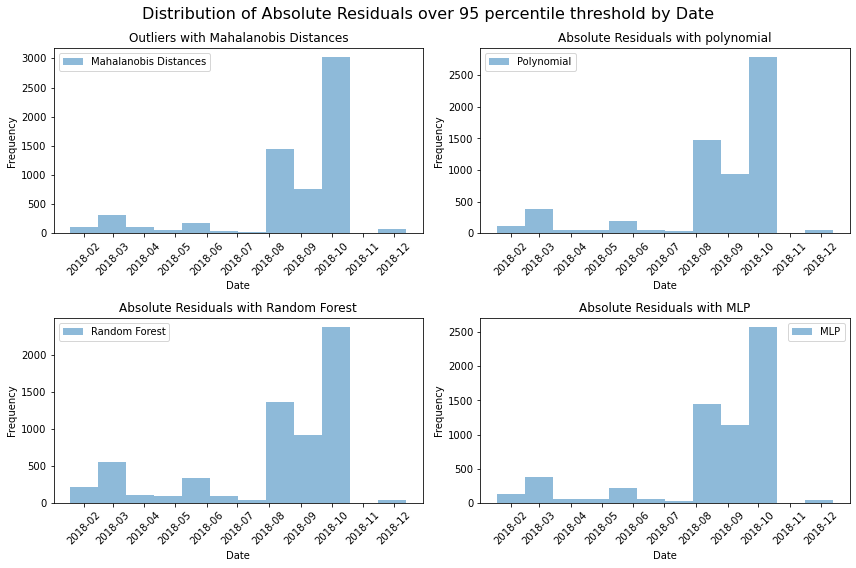

In [39]:
plt.figure(figsize=(12,8))

#All data points
plt.subplot(2, 2, 1)
plt.hist(unsupervised_df_scaled.index[outliers_mahalanobis], bins=12, alpha=0.5, label='Mahalanobis Distances')
plt.title('Outliers with Mahalanobis Distances')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

# Polynomial
plt.subplot(2, 2, 2)
plt.hist(X_combined.index[outliers_poly], bins=12, alpha=0.5, label='Polynomial')
plt.title('Absolute Residuals with polynomial')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

# Random Forest
plt.subplot(2, 2, 3)
plt.hist(X_combined.index[outliers_rf], bins=12, alpha=0.5, label='Random Forest')
plt.title('Absolute Residuals with Random Forest')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

# MLP
plt.subplot(2, 2, 4)
plt.hist(X_combined.index[outliers_mlp], bins=12, alpha=0.5, label='MLP')
plt.title('Absolute Residuals with MLP')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Distribution of Absolute Residuals over 95 percentile threshold by Date', fontsize=16)

plt.tight_layout()
plt.show()

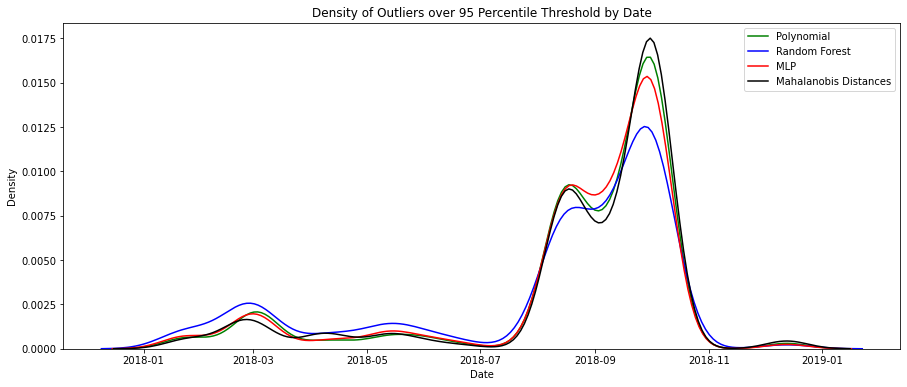

In [30]:
plt.figure(figsize=(15, 6))

# Polynomial
sns.kdeplot(X_combined.index[outliers_poly], color='green', label='Polynomial')

# Random Forest
sns.kdeplot(X_combined.index[outliers_rf], color='blue', label='Random Forest')

# MLP
sns.kdeplot(X_combined.index[outliers_mlp], color='red', label='MLP')

#Mahalanobis Distances
sns.kdeplot(unsupervised_df_scaled.index[outliers_mahalanobis], color='Black', label='Mahalanobis Distances')

plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Outliers over 95 Percentile Threshold by Date')
plt.legend()

plt.show()